## Load data

– Identify cases where changes in Renewals process are not being translated to KPIs, identify improvement opportunities of Renewals Dashboard, communicate insights about renewals: usage of custom fields, tags, triggers, handoffs and outcomes

In [275]:
import os
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

# Mount the Google Drive to access shared drives
drive.mount('/content/drive')

# Path to your shared drive (update this path as needed)
shared_drive_path = '/content/drive/My Drive/Renewals_csvs'

# One row per ticket, merges users, ticket events, department changes and customers
# Relevant Features per Ticket
df = pd.read_csv('/content/drive/My Drive/Renewals_csvs/bquxjob_5d686f4d_19554626267.csv')
# Adding billing frequency to df
df_terms_per_ticket_id = pd.read_csv('/content/drive/My Drive/Renewals_csvs/bquxjob_30dfa8fb_19569293834.csv')
df = pd.merge(df, df_terms_per_ticket_id, on='ticket_id', how='left')
#df = pd.merge(df, df_terms_per_instance, left_on='zendesk_account_id',right_on='instance_account_id', how='left')
# Market Segment and Customer facing logic per Ticket
df2 = pd.read_csv('/content/drive/My Drive/Renewals_csvs/bquxjob_4c85cef_1955d9ddf8f.csv')
# Intend tags per Ticket
df3 = pd.read_csv('/content/drive/My Drive/Renewals_csvs/bquxjob_27dcf080_195546fac11.csv')
# Handoffs related tags
df3_handoffs = pd.read_csv('/content/drive/My Drive/Renewals_csvs/bquxjob_5dd18c6b_1955d389b33.csv')
df3_handoffs.drop(columns=['solved_at_date'], inplace=True)
#One row per instance, helpful to understand engagement rate of Annual clients based on the moment the ticket was submitted
#Engagement Rate Analysis for Annual Instances
df4 = pd.read_csv('/content/drive/My Drive/Renewals_csvs/bquxjob_66ac43cc_19554b8c285.csv')
# df4 is aggregated, the following csv has one row per instance
df4_ = pd.read_csv('/content/drive/My Drive/Renewals_csvs/bquxjob_72fdd6ea_1955a446dfa.csv')
# Upcoming Subscriptions Endings
df5 = pd.read_csv('/content/drive/My Drive/Renewals_csvs/bquxjob_65496c0d_1955a6b81e7.csv')
# Tix with 1wfm tag
df6 = pd.read_csv('/content/drive/My Drive/Renewals_csvs/bquxjob_b9d3e6f_1955a87f7ce.csv')
# Commonly Shared Articles
df7 = pd.read_csv('/content/drive/My Drive/Renewals_csvs/bquxjob_21d6c9c4_1955a5d7981.csv')
# Tickets not Found in the Department Changes Table
df8 = pd.read_csv('/content/drive/My Drive/Renewals_csvs/bquxjob_7b853df3_1955f8fec00.csv')
# Analysis of tix submitted per year  by crm_win_dt and crm_churn_dt
df9 = pd.read_csv('/content/drive/My Drive/Renewals_csvs/bquxjob_7a489cc5_195618a34c6.csv')
# Tickets submitted to active instances ratio per ARR band and billing term
df10 = pd.read_csv('/content/drive/My Drive/Renewals_csvs/Engagement per band and crm_term - Renewals Forecasting - Engagement_rates_per_arr_band_and_term.csv')
# Adding fields to df
# @title
# Define the bins and labels for the categories
bins = [-1, 0, 1, 2, 3, float('inf')]  # Use float('inf') for 4 or greater
labels = [0, 1, 2, 3, 4]  # Corresponding labels for each bin
# Create the handoffs_category column
df['handoffs_category'] = pd.cut(df['No_of_handoffs'], bins=bins, labels=labels)

# Define the list of known ticket form names
main_forms = ['Renewals', 'Sales', 'General Form', 'RevOps', 'Collections', 'Support Ticket Form']

# Create the mapped column using np.where
df['ticket_form_name_'] = np.where(
    df['ticket_form_name'].isin(main_forms),
    df['ticket_form_name'],
    'Other'
)
# Fill NaN values with 'Null_value'
df['ticket_form_name_'] = df['ticket_form_name_'].replace('', 'Other').fillna('Null_value')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [276]:
# @title
# prompt: inner join df and df2 and df3 using ticket id

df = pd.merge(df, df2, on='ticket_id', how='inner')
df = pd.merge(df, df3, on='ticket_id', how='inner')
df = pd.merge(df, df3_handoffs, on='ticket_id', how='inner')


## Transformation steps/ Functions/ Filters

In [277]:
# Extract year and month as integers
df[['year', 'month']] = df['year_month'].str.split('-', expand=True)
df['year'] = df['year'].astype(int)
df['month'] = df['month'].astype(int)

# Create a mapping for the descriptive labels
label_mapping = {
    'arr_greater_than_100k': '100K+',
    'arr_is_null_or_zero': 'null_cero',
    'arr_less_than_12k': 'less_than_12k',
    'arr_between_12k_and_100k': '$12K to $100K',
    'arr_unknown': 'unknown'
}

bins = [-1, 0, 12000, 100000, float('inf')]  # Define the bins
labels = ['Zero or Negative', '$12K or Less', '$12K to $100K', 'Above $100K']  # Define the labels

# Create the ARR_category column using pd.cut
df['ARR_category'] = pd.cut(df['ARR_cf'], bins=bins, labels=labels, include_lowest=True)

# Create the ARR_band column using the mapping
df['ARR_band'] = df.apply(lambda row: next((label_mapping[col] for col in label_mapping if row[col] == 1), None), axis=1)

# Creating new columns based on the conditions
df['More_than_1_handoff'] = (df['handoffs_category'] > 1).astype(int)  # Column for greater than 1
df['More_than_2_handoffs'] = (df['handoffs_category'] > 2).astype(int)  # Column for greater than 2
df['More_than_3_handoffs'] = (df['handoffs_category'] > 3).astype(int)  # Column for greater than 3

# Filter for data between January 2024 and October 2024
df_ten_months = df[(df['year'] == 2024) & (df['month'] >= 1) & (df['month'] <= 10)]

# Filter for data after November 2024
df_after_oct_24 = df[(df['year'] > 2024) | ((df['year'] == 2024) & (df['month'] > 11))]
def plot_crm_distribution(df, crm_term_column):
    """
    Plots the distribution of CRM terms and the percentage of tickets submitted per type of CRM term.

    Parameters:
        df (DataFrame): The input DataFrame containing CRM term data.
        crm_term_column (str): The name of the column in the DataFrame that contains CRM terms.
    """
    # Calculate the percentage of tickets per crm_term
    crm_term_counts = df[crm_term_column].value_counts(normalize=True) * 100

    # Fill NaN values with 'Unknown'
    df[crm_term_column].fillna('Unknown', inplace=True)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot the bar chart
    df[crm_term_column].value_counts().plot(kind='bar', ax=ax1, color='#028079')

    ax1.set_xlabel("CRM Term")
    ax1.set_ylabel("Number of Tickets", color='#028079')
    ax1.tick_params(axis='y', labelcolor='#028079')

    # Rotate x-axis labels
    plt.xticks(rotation=45, ha="right")

    # Create a secondary axis for the scatter plot
    ax2 = ax1.twinx()

    # Plot the scatter plot with secondary axis
    ax2.scatter(crm_term_counts.index, crm_term_counts.values, color='#17494D', marker='x', s=50)
    ax2.set_ylabel("Percentage of Tickets (%)", color='#17494D')
    ax2.tick_params(axis='y', labelcolor='#17494D')

    # Add title and legend (optional)
    plt.title(f'Distribution and Percentage of Tickets - {crm_term_column}')

    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()

# Example usage:
# Assuming 'df' is your DataFrame and 'crm_term' is the column name

def plot_percentage_bars(df, columns):
    """
    Plots the percentage of 1s for specified columns in a bar plot.

    Parameters:
        df (DataFrame): The input DataFrame containing binary columns.
        columns (list): List of column names to plot.
    """
    # Calculate the percentage of 1s for each specified column
    percentages = [(df[col].mean() * 100) for col in columns]
    # Create a DataFrame to hold columns and their corresponding percentages
    percentage_df = pd.DataFrame({'Column': columns, 'Percentage': percentages})

    # Sort the DataFrame by percentage in descending order
    percentage_df = percentage_df.sort_values(by='Percentage', ascending=False)
    percentage_df = percentage_df.head(20)

    # Create the bar plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(percentage_df['Column'], percentage_df['Percentage'], color='#028079')

    # Add percentage labels on top of the bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%',
                ha='center', va='bottom', fontsize=10)

    # Set the labels and title
    ax.set_ylabel('Percentage of 1s (%)')
    ax.set_xlabel('Columns')
    ax.set_title('Percentage of 1s in Specified Columns')
    ax.set_ylim(0, 100)  # Set y-axis limits from 0 to 100

    # Rotate x-axis labels if necessary
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()

    # Assuming 'df' is your DataFrame and you have binary columns like 'col1', 'col2', etc.
columns_to_plot = [
    'has_custom_field',
    'is_requester_valid',
    'is_submitter_valid',
    'arr_greater_than_100k',
    'arr_is_null_or_zero',
    'arr_less_than_12k',
    'arr_between_12k_and_100k',
    'arr_unknown',
    'is_zd',
    'has_public_comment',
    'cust_facing',
    'closed_by_merge_tag',
    'seat_contraction_tag',
    'finance_ops_renewal_downgrade_tag',
    'plan_downgrade_tag',
    'churn_notice_tag',
    'quote_support_tag',
    'billing_change_tag',
    'term_change_tag',
    'renewal_conversation_tag',
    'seat_and_product_contraction_tag',
    'product_contraction_tag',
    'save_play_tag',
    'finance_ops_renewal_change_tag',
    'paperwork_request_tag',
    'close_me_now',
    'unsolicited_spam',
    'has_intend',
    'tag_1wfm_left_advocacy_tymeshift',
    'tag_ticket_cc_routing_renewals_left_triage',
    'tag_1wfm_left_advocacy_customer_care_tier2',
    'tag_1wfm_left_advocacy',
    'tag_1wfm_left_online_sales',
    'tag_1wfm_left_advocacy_zendesk_qa',
    'tag_1wfm_left_cx',
    'tag_1wfm_left_renewals',
]


columns_to_plot_ = ['cust_facing',
 'has_custom_field',
 'has_public_comment',
 'has_intend',
 'tag_ticket_cc_routing_renewals_left_triage',
 'is_submitter_valid',
 'seat_contraction_tag',
 'is_zd',
 'is_requester_valid',
 'tag_1wfm_left_advocacy',
 'tag_1wfm_left_online_sales',
 'churn_notice_tag',
 'closed_by_merge_tag',
 'renewal_conversation_tag',
 'quote_support_tag']

columns_to_plot_arr = [
 'arr_between_12k_and_100k',
 'arr_is_null_or_zero',
 'arr_less_than_12k',
 'arr_unknown',
 'arr_greater_than_100k']

# List of columns related to routing
columns_to_plot_routing = [
    'tag_ticket_cc_routing_renewals_left_triage',
    'tag_1wfm_left_advocacy',
    'tag_1wfm_left_online_sales',
]

# Adding the new columns to the columns_to_plot_routing list
columns_to_plot_routing.extend(['More_than_1_handoff', 'More_than_2_handoffs', 'More_than_3_handoffs'])

# List of columns related to intent (renewals and churn)
columns_to_plot_intend = [
    'seat_contraction_tag',
    'finance_ops_renewal_downgrade_tag',
    'plan_downgrade_tag',
    'churn_notice_tag',
    'quote_support_tag',
    'billing_change_tag',
    'term_change_tag',
    'renewal_conversation_tag',
    'seat_and_product_contraction_tag',
    'product_contraction_tag',
    'save_play_tag',
    'finance_ops_renewal_change_tag',
    'paperwork_request_tag',
    'has_intend'
]


# List of columns related to indicators
columns_to_plot_indicators = [
    'has_custom_field',
    'is_requester_valid',
    'is_submitter_valid',
    'is_zd',
    'has_public_comment',
    'cust_facing'
]
def plot_percentage_bars_comparison(df1, df2, columns):
    """
    Plots the percentage of 1s for specified columns in a bar plot for two DataFrames.

    Parameters:
        df1 (DataFrame): The first input DataFrame containing binary columns.
        df2 (DataFrame): The second input DataFrame containing binary columns.
        columns (list): List of column names to plot.
    """
    # Calculate the percentage of 1s for each specified column in both DataFrames
    percentages_df1 = [(df1[col].mean() * 100) for col in columns]
    percentages_df2 = [(df2[col].mean() * 100) for col in columns]

    # Set the positions of the bars on the x-axis
    bar_width = 0.35
    x = range(len(columns))

    # Create the bar plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create bars for the first DataFrame
    bars1 = ax.bar([i - bar_width/2 for i in x], percentages_df1, width=bar_width, color='#028079', label='2024 Jan-Oct')

    # Create bars for the second DataFrame
    bars2 = ax.bar([i + bar_width/2 for i in x], percentages_df2, width=bar_width, color='#00A656', label='After Nov 2024')

    # Add percentage labels on top of the bars
    for bar in bars1:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}%',
                ha='center', va='bottom', fontsize=10)

    for bar in bars2:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}%',
                ha='center', va='bottom', fontsize=10)

    # Set the labels and title
    ax.set_ylabel('Percentage of Tickets Meeting Key Indicators (%)')
    ax.set_xlabel('Columns')
    ax.set_title('Comparison of Tickets Meeting Key Indicators Before vs After Renewals Process Update')
    ax.set_ylim(0, 100)  # Set y-axis limits from 0 to 100

    # Set x-ticks to the column names
    ax.set_xticks(x)
    ax.set_xticklabels(columns, rotation=45, ha='right')

    # Add a legend
    ax.legend()

    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()

In [278]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_percentage_bars_comparison(df1, df2, columns):
    """
    Plots the percentage of tickets meeting specified key metrics in a bar plot for two DataFrames.

    Parameters:
        df1 (DataFrame): The first input DataFrame containing binary columns.
        df2 (DataFrame): The second input DataFrame containing binary columns.
        columns (list): List of column names to plot.
    """
    # Calculate the percentage of 1s for each specified column in both DataFrames
    percentages_df1 = [(df1[col].mean() * 100) for col in columns]
    percentages_df2 = [(df2[col].mean() * 100) for col in columns]

    # Create a DataFrame to combine and sort the percentages
    combined_df = pd.DataFrame({
        'Column': columns,
        'Percentage_df1': percentages_df1,
        'Percentage_df2': percentages_df2
    })

    # Calculate the maximum percentage for sorting (you can choose to sort by either df1 or df2)
    combined_df['Max_Percentage'] = combined_df[['Percentage_df1', 'Percentage_df2']].max(axis=1)

    # Sort the combined DataFrame based on the maximum percentage
    combined_df = combined_df.sort_values(by='Max_Percentage', ascending=False)

    # Set the positions of the bars on the x-axis
    bar_width = 0.35
    x = range(len(combined_df))

    # Create the bar plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create bars for the first DataFrame
    bars1 = ax.bar([i - bar_width/2 for i in x], combined_df['Percentage_df1'], width=bar_width, color='#028079', label='2024 Jan-Oct')

    # Create bars for the second DataFrame
    bars2 = ax.bar([i + bar_width/2 for i in x], combined_df['Percentage_df2'], width=bar_width, color='#00A656', label='After Nov 2024')

    # Add percentage labels on top of the bars
    for bar in bars1:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}%',
                ha='center', va='bottom', fontsize=10)

    for bar in bars2:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}%',
                ha='center', va='bottom', fontsize=10)

    # Set the labels and title
    ax.set_ylabel('Percentage of Tickets Meeting Key Indicators (%)')
    ax.set_xlabel('Columns')
    ax.set_title('Comparison of Tickets Meeting Key Indicators Before vs After Renewals Process Update')
    ax.set_ylim(0, 100)  # Set y-axis limits from 0 to 100

    # Set x-ticks to the sorted column names
    ax.set_xticks(x)
    ax.set_xticklabels(combined_df['Column'], rotation=45, ha='right')

    # Add a legend
    ax.legend()

    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()

## Summary

[Relevant Features per Ticket](https://docs.google.com/document/d/1GU-YOM7fNbiHZ5shpqK4m1sAASrhusuwDwy9Wkns8vw/edit?usp=sharing)

**tickets table**
* ticket form
  * More than 20 % of tickets do not have a ticket form
  * 17 % of tickets solved by Renewals used Sales, RevOps or Collections ticket forms
    * The use of those tags is trending down, specially after July 2024
* has custom field
  * the most common custom field is market segment, when a ticket has no market segment and Zendesk instance it tends to be an internal ticket. It is not 100% accurate but it is the current best way we have found to identify if a ticket is internal or no.
  * 13% of Renewal tickets do not have a custom field
* ttc
  * ttc band days
* requester and submitter
  - When value is not null it implies that someone internal is submitting or requesting the ticket
  - This fields can be used to analyze the role e.g. AE on behalf of the client or a Renewals Representative esclating the ticket.

* 7 to 8% of tickets have closed by merge tag

**Ticket events table**
* public comments count
  * public comments count category
  * A lack of public comments is also used to identify if a ticket is customer facing

**Customers table**
* ARR
  * ARR band
  * ARR Band hot encoding
    * Greater than 100K
    * null or cero
    * Less than 12K
    * 12 to 100K


**Department changes table**
* handoff counts
  * group count category

**Custom fields included in tickets table**
* renewal date
* ARR

Output is classified to rate complexity e.g. tickets taking too long, having several handoffs and high resolution times

**Billing Frequency**
* [crm_term](https://docs.google.com/document/d/1UswxP0AlAYfDtigE1Gg3kur-GuIH3FGoxqJOcRR6KN0/edit?usp=sharing)





[market segment and customer facing logic per ticket_id
](https://docs.google.com/document/d/1abj4cCjxVEMsQ0EU5r6g2hB-kGZEhmLnWe7oo__tz9s/edit?usp=sharing)


**13% of Renewals tickets do not have a market segment**

Those tickets tend to be used for internal communication

In some of the tickets opened, the conversation takes place through another channel e.g. Mail or chat and then the conclusion or agreement is added as an internal note to a ticket


* Source: ticket_events
* Date: 2024-05-01
* Department: Renewals
* Additional filters: No

In [279]:
df.handoffs_category.value_counts()

,count
handoffs_category,
0,4787
1,2513
2,1647
4,1018
3,809


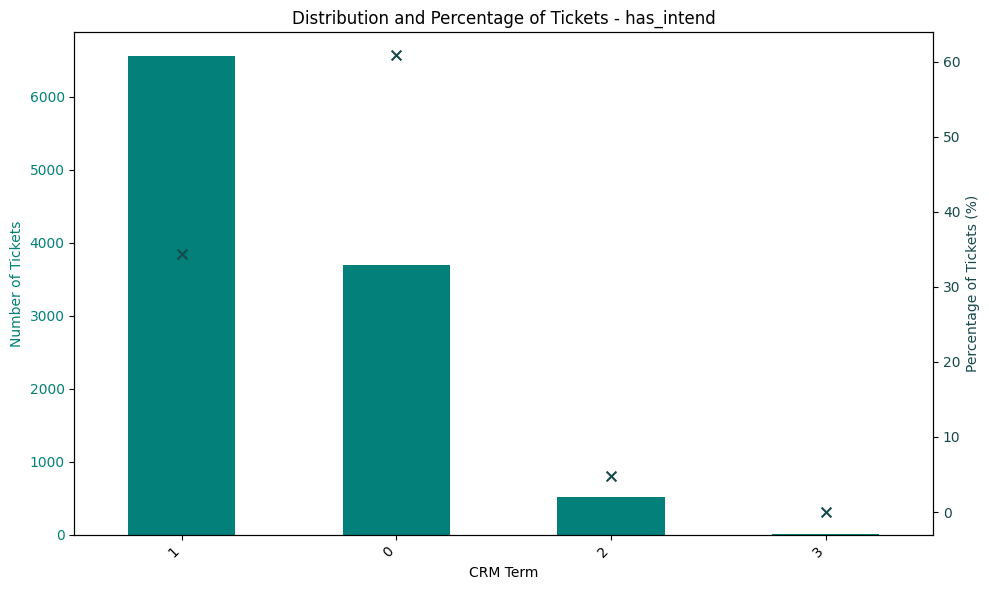

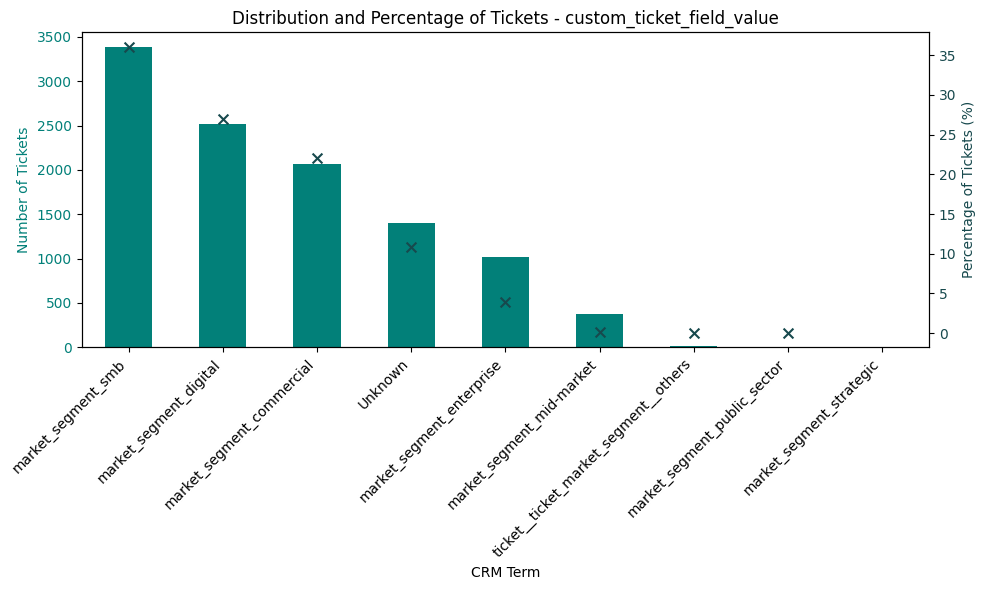

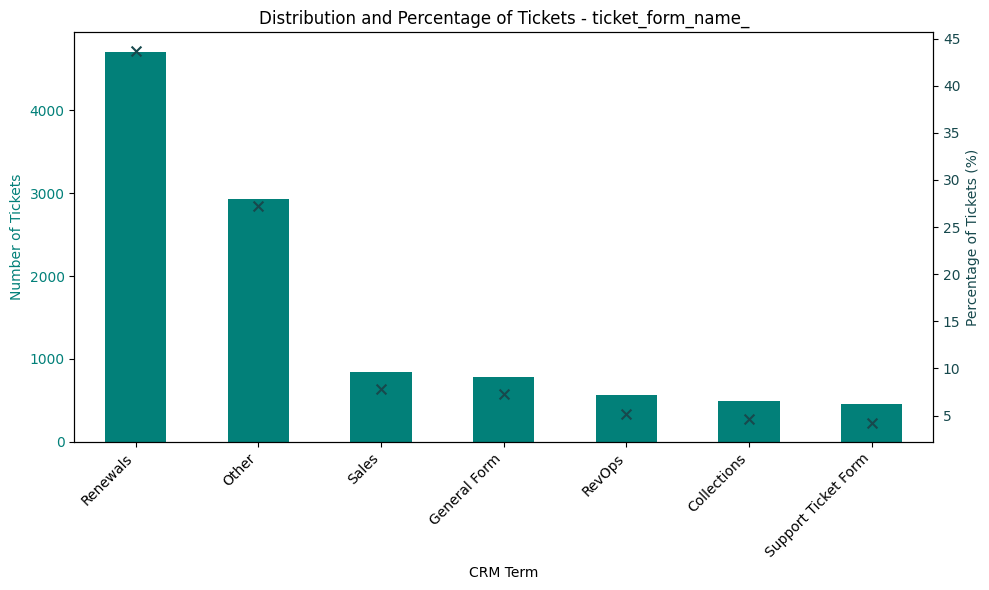

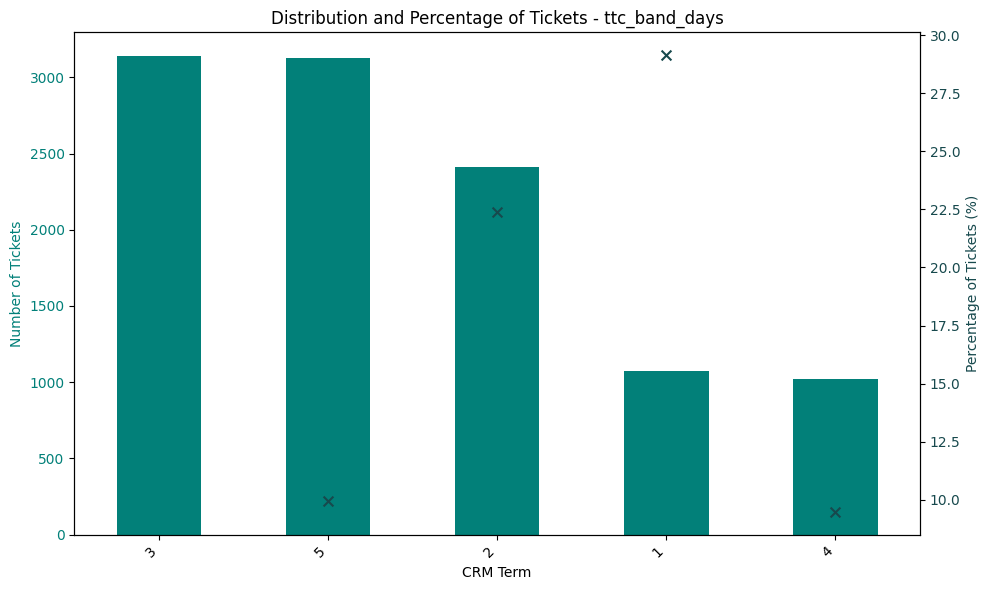

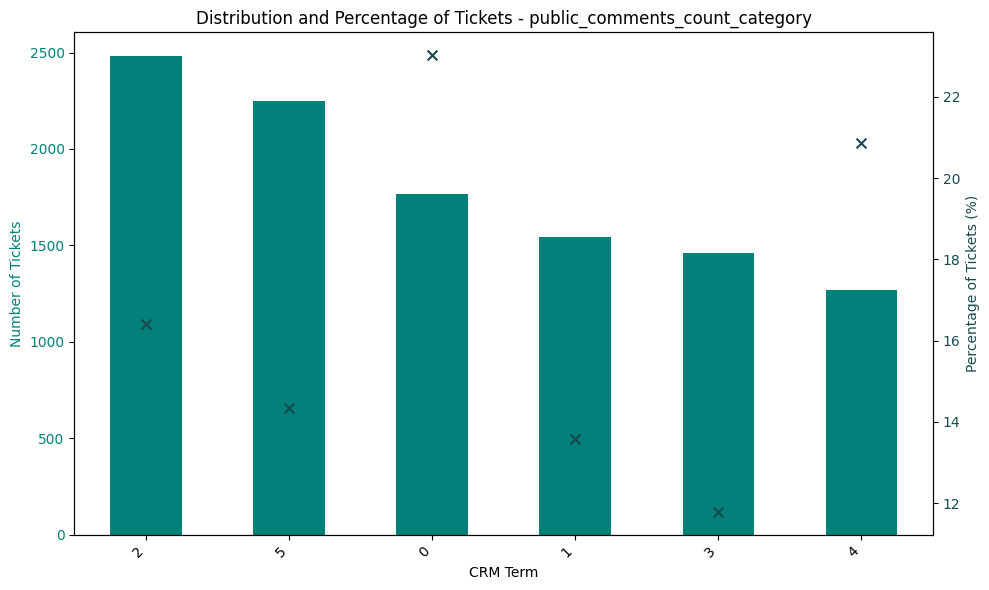

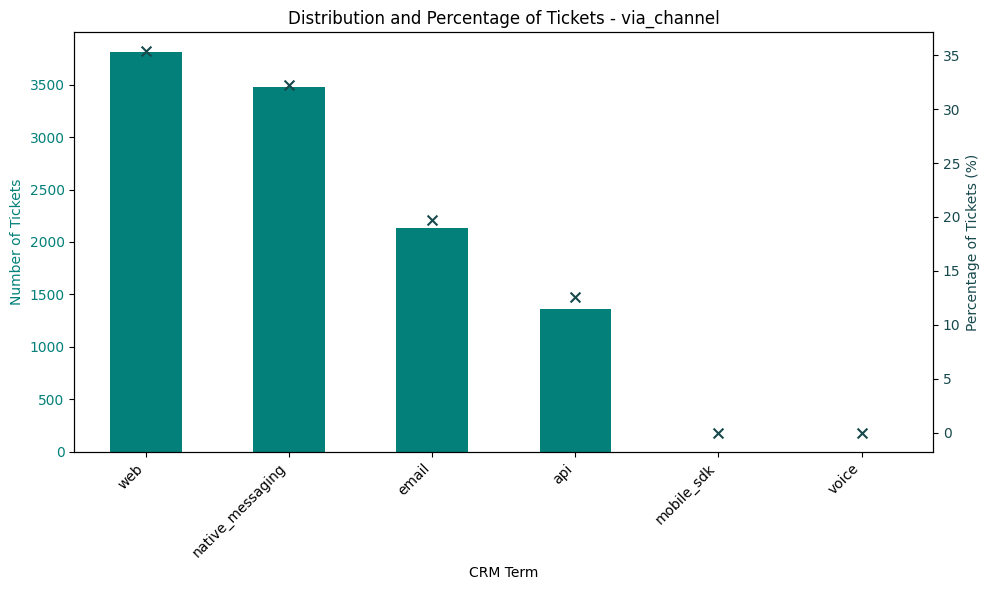

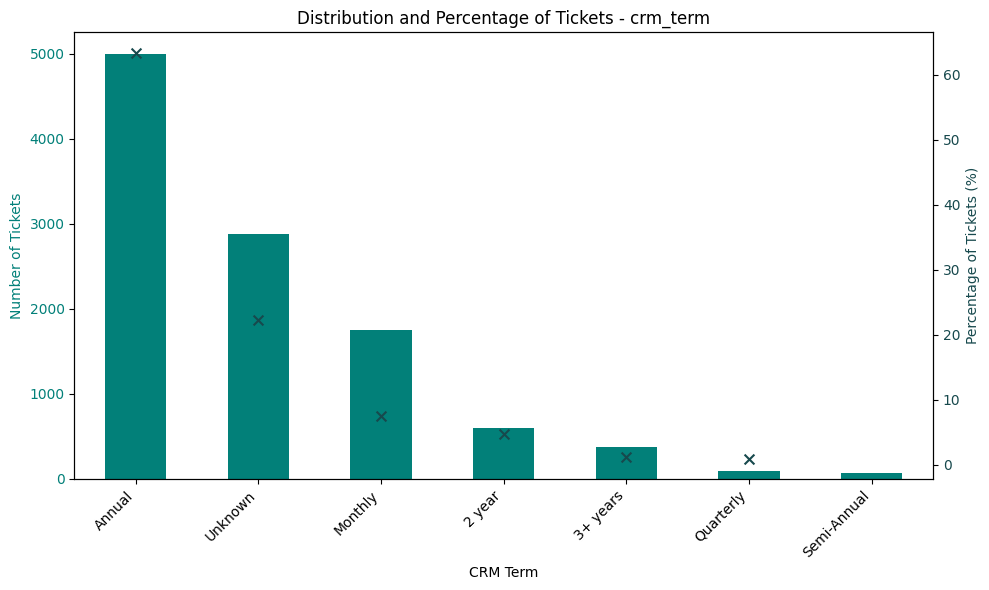

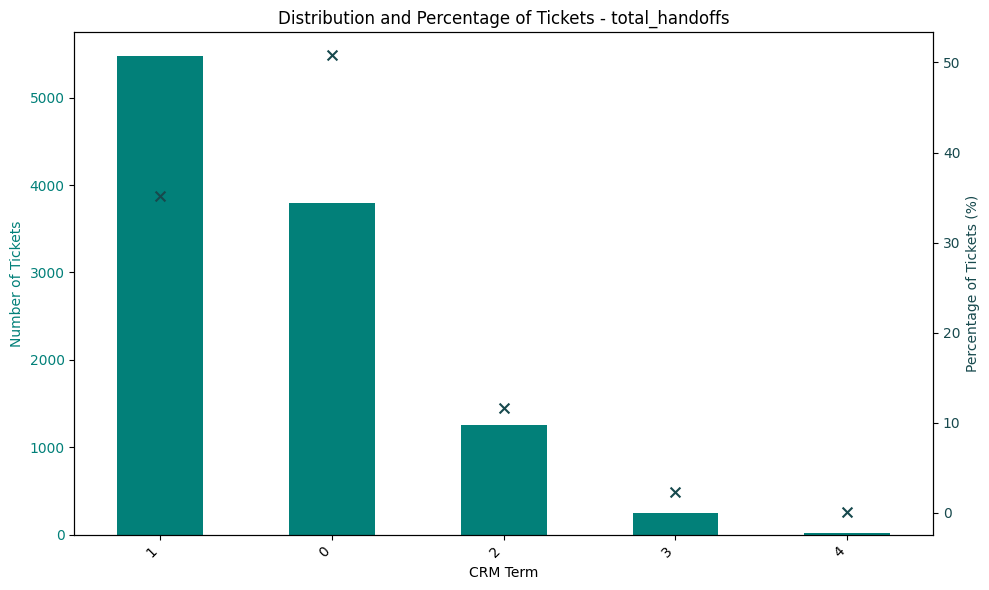

In [280]:
# @title
# Assuming 'df' is your DataFrame containing the relevant columns
# List of columns to plot
columns_to_plot = [
    'has_intend',
    'custom_ticket_field_value',
    'ticket_form_name_',
    'ttc_band_days',
    'public_comments_count_category',
    'via_channel',
    'crm_term',
    'total_handoffs'
    #'ARR_category'
]
# Call the plotting function for each column
for column in columns_to_plot:
    plot_crm_distribution(df, column)

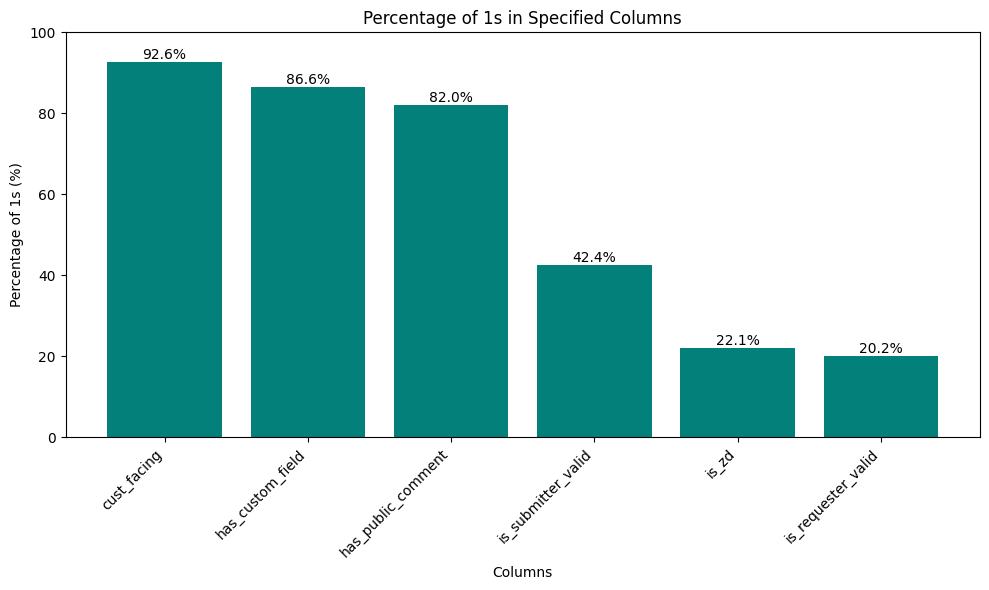

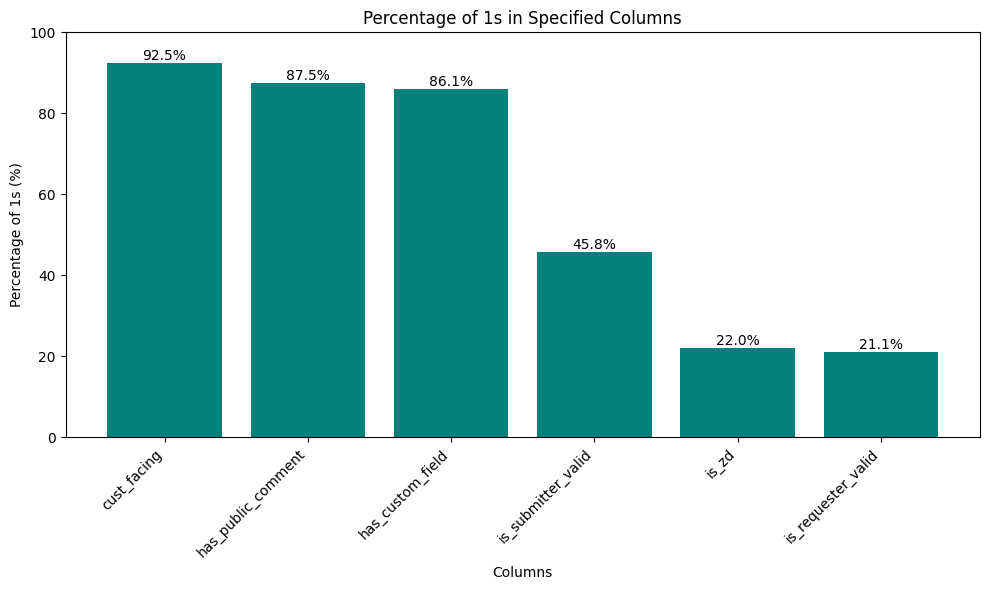

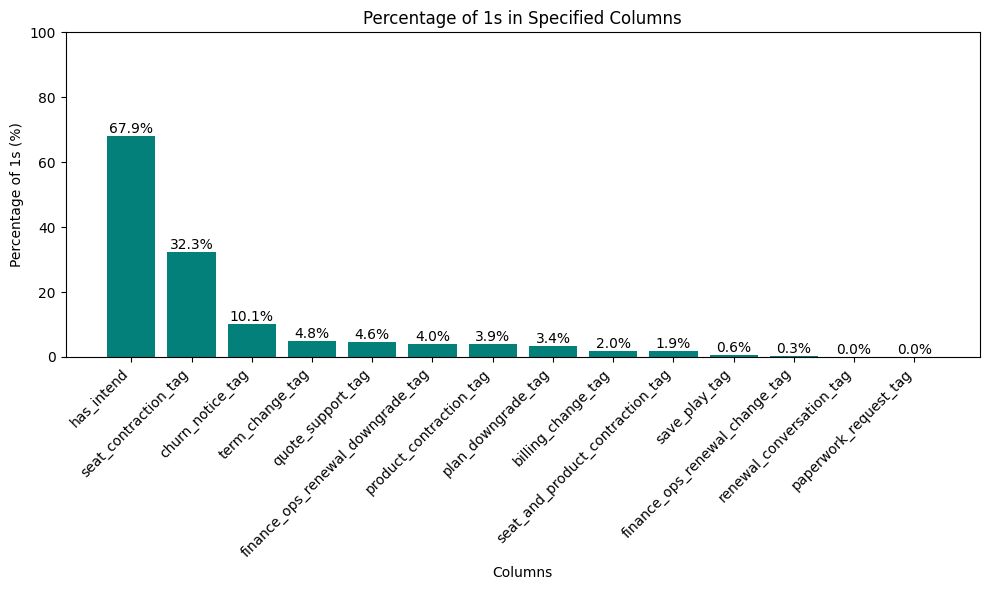

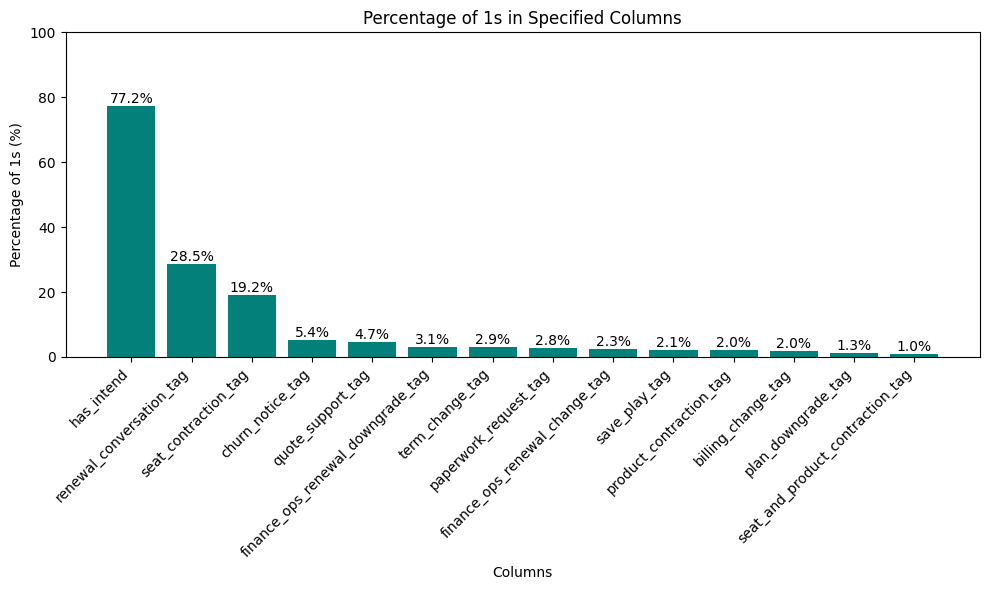

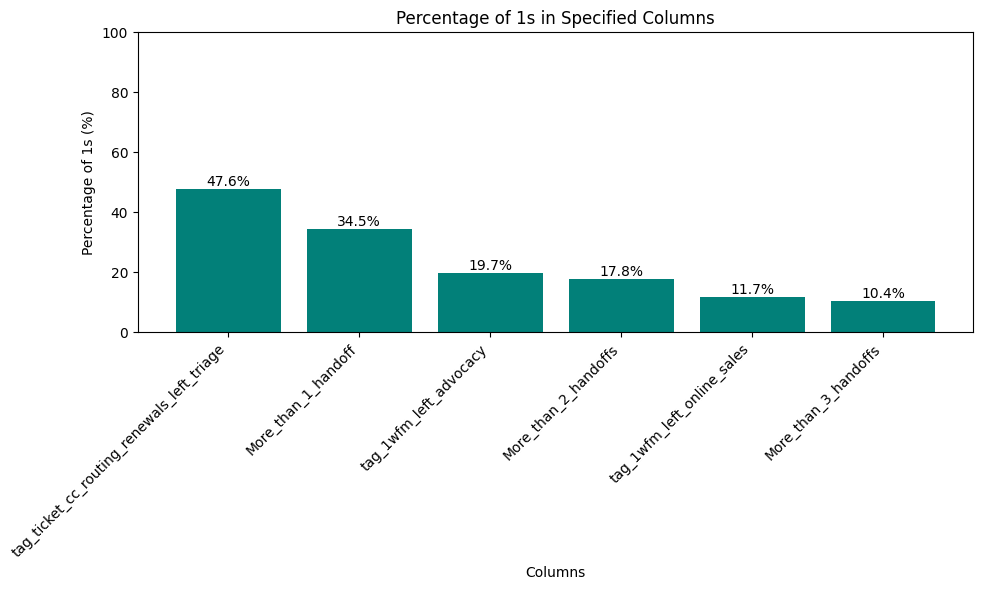

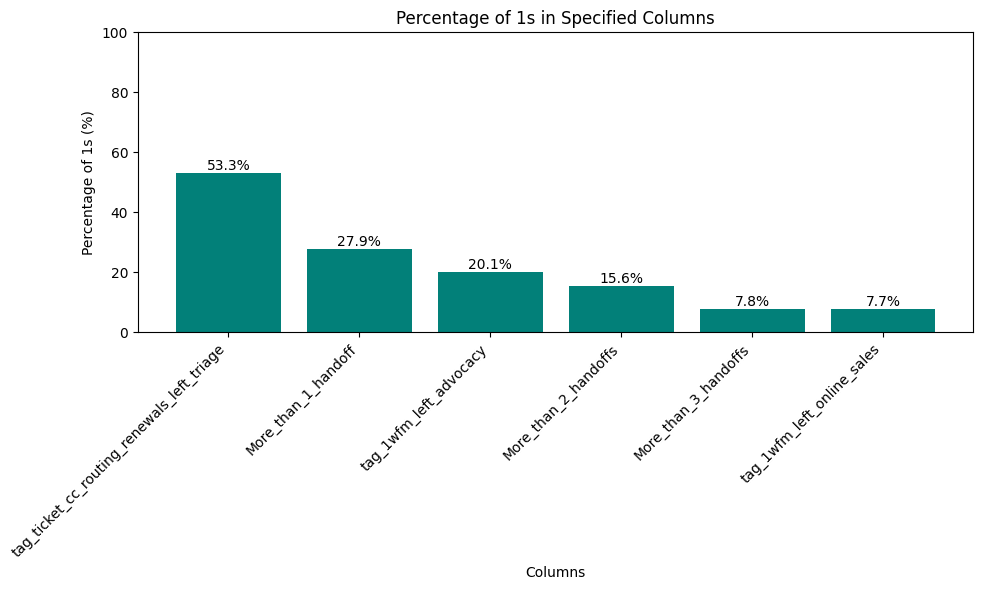

In [281]:

# Call the function for indicators
plot_percentage_bars(df_ten_months, columns_to_plot_indicators)
plot_percentage_bars(df_after_oct_24, columns_to_plot_indicators)


# Call the function for intend (renewals and churn)
plot_percentage_bars(df_ten_months, columns_to_plot_intend)
plot_percentage_bars(df_after_oct_24, columns_to_plot_intend)

# Call the function for routing
plot_percentage_bars(df_ten_months, columns_to_plot_routing)
plot_percentage_bars(df_after_oct_24, columns_to_plot_routing)

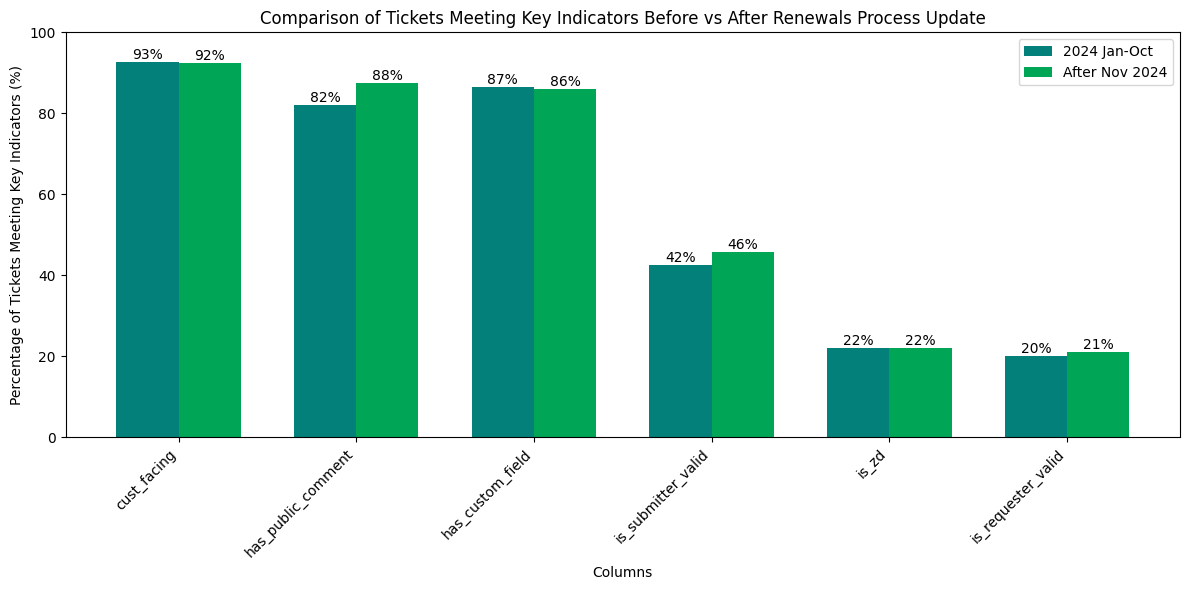

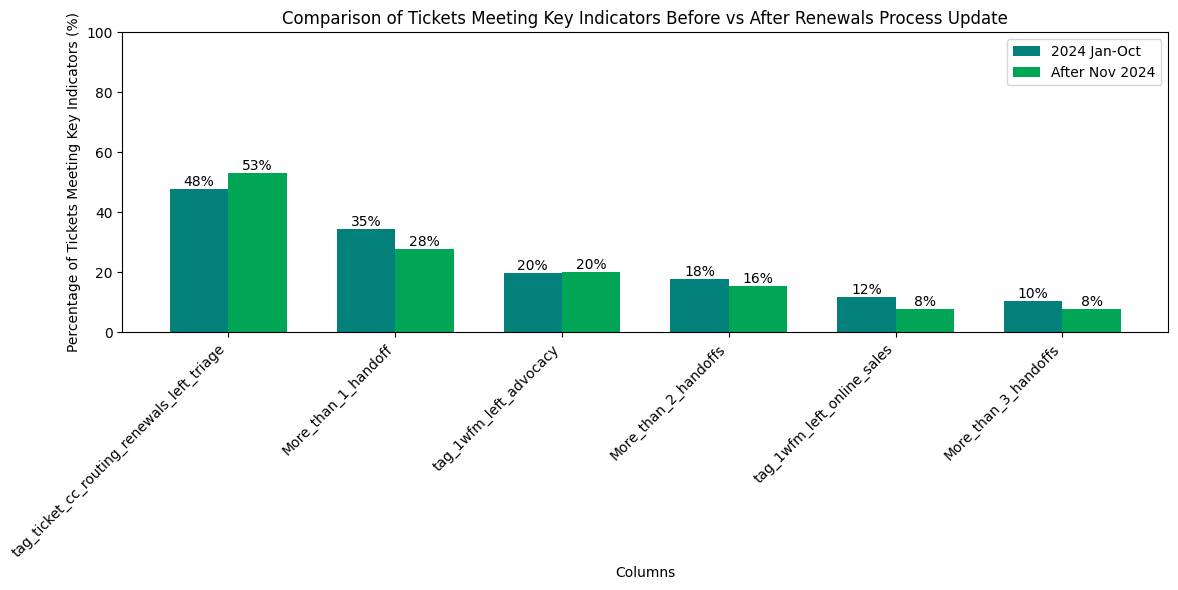

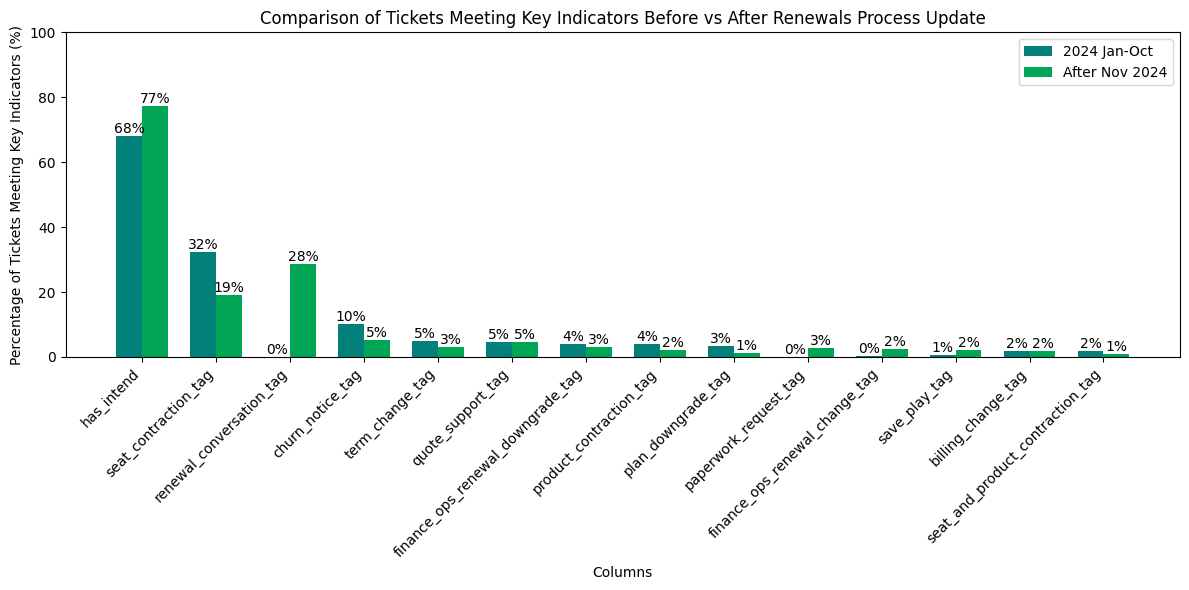

In [282]:


# Example usage:
# Assuming 'df_after_oct_24' and 'df_ten_months' are your DataFrames and you have binary columns like 'col1', 'col2', etc.
plot_percentage_bars_comparison(df_ten_months, df_after_oct_24, columns_to_plot_indicators)
plot_percentage_bars_comparison(df_ten_months, df_after_oct_24, columns_to_plot_routing)
plot_percentage_bars_comparison(df_ten_months, df_after_oct_24, columns_to_plot_intend)


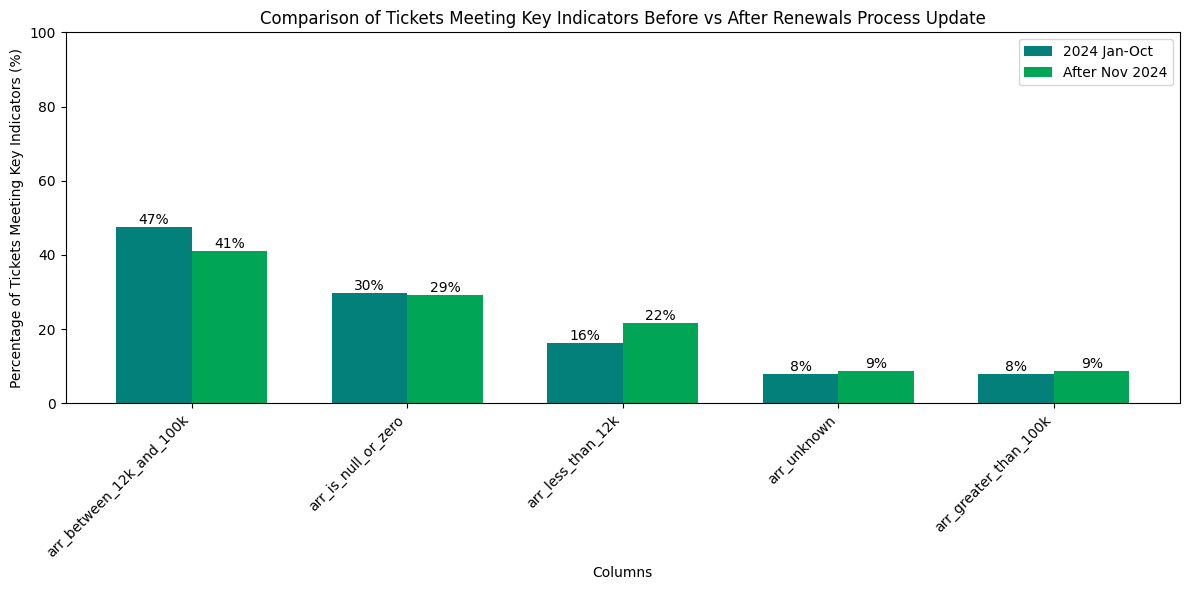

In [283]:
plot_percentage_bars_comparison(df_after_oct_24, df_ten_months, columns_to_plot_arr)

In [284]:
df.head()

,ticket_id,year_month,full_resolution_time_in_minutes_calendar,instance_account_id,via_channel,ticket_form_name,has_custom_field,is_requester_valid,is_submitter_valid,requester_id,...,tag_1wfm_left_cx,tag_1wfm_left_renewals,total_handoffs,year,month,ARR_category,ARR_band,More_than_1_handoff,More_than_2_handoffs,More_than_3_handoffs
0,12749206,2024-07,38876,9220710.0,native_messaging,NaN,1,0,0,1265146920870,...,0,0,1,2024,7,NaN,$12K to $100K,0,0,0
1,12625984,2024-09,158709,1995869.0,native_messaging,Renewals,1,0,0,1265003166450,...,0,0,1,2024,9,$12K to $100K,$12K to $100K,1,1,1
2,12761758,2024-08,42955,14721789.0,web,Renewals,1,0,0,4887763465498,...,0,0,1,2024,8,$12K to $100K,$12K to $100K,0,0,0
3,12953818,2024-09,12007,9322043.0,native_messaging,Sales,1,0,0,5901321929370,...,0,0,1,2024,9,$12K to $100K,$12K to $100K,1,1,0
4,12771190,2024-07,18969,19407935.0,native_messaging,Renewals,1,0,0,6612046070554,...,0,0,1,2024,7,$12K or Less,$12K to $100K,1,0,0


[Intend_related_tags_per_ticket](https://docs.google.com/document/d/1iV8VC0akBt5e9RnYFIKanDSxGSpaFnsiMlfcBrmtRO4/edit?usp=sharing)


Hot encoding for popular **intend tags** within Renewals tickets

Hot encoding for tickets without intend

* Almost 30% of tickets do not have intend


[Handoffs related tags](https://docs.google.com/document/d/1RfPlRtjUyIGi3KnrJR1y68JU8nqW83GCLXCAF_j7A80/edit?usp=sharing)


The most common tag is Tickets handed off from Triage to Renewals

In second place, more than [200 tickets per month](https://colab.research.google.com/drive/1ZdwRfJA1v8uxuR1IEftfXLwLjGqmGqaN#scrollTo=YnTuSs_465BD&line=6&uniqifier=1) were handed off from Advocacy to Renewals

In third place, almost 100 tickets per month were handed off from Online Sales to Renewals

[Engagement Rate Analysis for Annual instances
](https://docs.google.com/document/d/10dUFtWl5VfQ9rnqec6M2Qm0mZCrRQN1RYPFsUz4ybAk/edit?usp=sharing)

* 2 Months Prior to Renewals
  * This is the typical moment to engage
    * 34% of tickets were submitted between 30 and 60 days prior tu Renewal date
* 12% of tickets were submitted before the subscription started or after the subscription ended
  * Those tickets were submitted to clarify once they received their bill.

[Commonly shared articles](https://docs.google.com/document/d/1L55BlBpY7YczZZ56bCl1rmEy6R_7iemdI2zcQ2oU43U/edit?usp=sharing)

*   Top 20 most shared articles
  * An interesting opportunity would be analyzing Unit Q monitors to check if there is an intend or a theme that is commonly inquired by clients and possibly there is no KCS article that is addressing those inquiries
  * The rate of articles that is shared is low, only 1 out of 10 tickets has had a kcs event.


[Analysis of Upcoming Subscription Endings by ARR Band and CRM Term](https://docs.google.com/document/d/1gXx_iNCTfd60K5Ghiub9GSbwwkGwKRKjyMacvyw8EVA/edit?usp=sharing)

[tix with 1wfm renewals tags between may 2024 and dec 2025](https://docs.google.com/document/d/10PPp8slLQ36G7ebID-_Z-U5ARA5cKEGLQaHtWTkefqY/edit?usp=sharing)



*   Between 1600 and 2100 tickets per month have the 1wfm renewals tag
*   Almost 40% of tickets are then handed off to another department and since Renewals did not close the ticket, those tickets are not being considered despite they implied certain work for the Renewals team



[tickets not found in the department changes table](https://docs.google.com/document/d/1GYJLfugfObjIsozXmMpmXSkSXehRWmeTdWDlPpOeRXc/edit?usp=sharing)

4% of tix were not found in the department changes table

[Analysis of tix submitted per year  by crm_win_dt and crm_churn_dt](https://docs.google.com/document/d/1_yJH0o_O_q5eXLqHKIpmag7SbUvOHWxLcu21bTVSQ9I/edit?usp=sharing)

Likelyhood of churning is greater when the customer is reaching Renewals?

[Tickets submitted to active instances ratio per ARR band and billing term](https://docs.google.com/spreadsheets/d/1Tt66qw3X__Piq0DO_kVmVPpBZxqVmuomXZDY9o5L82Y/edit?gid=1088062948#gid=1088062948&range=F2)

 Ratio of tickets submitted to active instances for instances with an Annual Recurring Revenue (ARR) band of less than `$12K, $12K` to `$100K and $100K+`. The dataset includes the number of tickets submitted alongside the corresponding instances count e.g. 249 tickets were submitted on Jan while 52k instances where active whereas almost 100 tickets where submitted in Sep or October when 48k instances where active.

 The ratio can differ widely despite having a similar amount of active instances.

In [285]:
df.crm_term.value_counts()

,count
crm_term,
Annual,5002
Unknown,2883
Monthly,1751
2 year,596
3+ years,376
Quarterly,93
Semi-Annual,73


In [286]:
# @title
nunique_df = df.nunique().reset_index()
nunique_df.columns = ['Column', 'Distinct Count']

# Select columns where the number of unique values is less than or equal to 10
categorical_columns = nunique_df[nunique_df['Distinct Count'] <= 10]['Column']

# Create a new DataFrame with only the selected categorical features
categorical_df = df[categorical_columns]

# Iterate over each feature and get value counts
for column in categorical_df.columns:
    value_counts = categorical_df[column].value_counts()
    print(f"Value counts for '{column}':")
    print(value_counts)
    print()

Value counts for 'year_month':
year_month
2024-07    1427
2024-05    1347
2024-06    1250
2024-08    1174
2025-02     956
2024-10     953
2025-01     947
2024-11     922
2024-09     918
2024-12     880
Name: count, dtype: int64

Value counts for 'via_channel':
via_channel
web                 3808
native_messaging    3476
email               2129
api                 1358
mobile_sdk             2
voice                  1
Name: count, dtype: int64

Value counts for 'has_custom_field':
has_custom_field
1    9377
0    1397
Name: count, dtype: int64

Value counts for 'is_requester_valid':
is_requester_valid
0    8547
1    2227
Name: count, dtype: int64

Value counts for 'is_submitter_valid':
is_submitter_valid
0    6081
1    4693
Name: count, dtype: int64

Value counts for 'arr_greater_than_100k':
arr_greater_than_100k
0    9831
1     943
Name: count, dtype: int64

Value counts for 'arr_is_null_or_zero':
arr_is_null_or_zero
0    7576
1    3198
Name: count, dtype: int64

Value counts for 'arr

In [287]:
df.ARR_band.value_counts()

,count
ARR_band,
$12K to $100K,4631
null_cero,3198
less_than_12k,2002
100K+,943


### Proportion of tickets lacking public comments for internal vs not internal tickets

In [288]:
# @title
# prompt: df cross tab is_zd and has_public_comment
# df query where has_custom_field == 1 vs has_custom_field == 0
# Comparison of groups based on 'has_custom_field'
has_custom_field_1 = df.query('has_custom_field == 1')
has_custom_field_0 = df.query('has_custom_field == 0')
# Cross-tabulation of 'is_zd' and 'has_public_comment'
cross_tab = pd.crosstab(df['is_zd'], df['has_public_comment'])
print("Cross-tabulation of 'is_zd' and 'has_public_comment':\n", cross_tab)





Cross-tabulation of 'is_zd' and 'has_public_comment':
 has_public_comment     0     1
is_zd                         
0                   1265  7104
1                    502  1903


In [289]:
# @title
pd.crosstab(has_custom_field_1['is_zd'], has_custom_field_1['has_public_comment'])

has_public_comment,0,1
is_zd,,
0,1192,6434
1,451,1300


In [290]:
# @title
pd.crosstab(has_custom_field_0['is_zd'], has_custom_field_0['has_public_comment'])

has_public_comment,0,1
is_zd,,
0,73,670
1,51,603


In [291]:
# Filter the DataFrame based on 'is_zd'
is_zd_true = df.query('is_zd == 1')
is_zd_false = df.query('is_zd == 0')

# Cross-tabulation of 'is_requester_valid' and 'is_submitter_valid'
cross_tab_validity = pd.crosstab(df['is_requester_valid'], df['is_submitter_valid'])

# Display the cross-tabulation
print(cross_tab_validity)

is_submitter_valid     0     1
is_requester_valid            
0                   6049  2498
1                     32  2195


In [292]:
pd.crosstab(is_zd_true['is_requester_valid'], is_zd_true['is_submitter_valid'])

is_submitter_valid,0,1
is_requester_valid,,
0,166,13
1,32,2194


In [293]:
is_zd_true.shape[0]

2405

In [294]:
166/is_zd_true.shape[0]

0.06902286902286903

In [295]:
is_zd_true.shape[0]/df.shape[0]

0.2232225728605903

In [296]:
pd.crosstab(is_zd_false['is_requester_valid'], is_zd_false['is_submitter_valid'])

is_submitter_valid,0,1
is_requester_valid,,
0,5883,2485
1,0,1


In [297]:
# @title
import pandas as pd
import plotly.express as px

def plot_comment_counts(df):
    # Create the crosstab
    crosstab = pd.crosstab(
        index=df['year_month'],
        columns=[df['is_zd'], df['has_public_comment']],
    )

    # Reset index to have 'year_month' as a column
    crosstab.reset_index(inplace=True)

    # Rename the columns for easier access
    crosstab.columns = ['year_month', 'not_zd_no_comment', 'not_zd_with_comment', 'zd_no_comment', 'zd_with_comment']

    # Melt the DataFrame to long format for Plotly
    melted_data = crosstab.melt(id_vars=['year_month'],
                                 value_vars=['not_zd_no_comment', 'not_zd_with_comment', 'zd_no_comment', 'zd_with_comment'],
                                 var_name='category',
                                 value_name='count')

    # Create the line plot with Plotly
    fig = px.line(melted_data,
                  x='year_month',
                  y='count',
                  color='category',
                  title='Counts of Comments by Year and Month',
                  color_discrete_sequence=['blue', 'orange', 'green', 'red'])  # Specify colors

    # Update legend properties for better visibility
    fig.update_layout(
        legend=dict(
            title="Comment Categories",
            font=dict(size=12),  # Increase font size for legend
            itemsizing='constant',  # Keep item sizes constant
            orientation='h'  # Horizontal orientation
        )
    )

    # Show the plot
    fig.show()

In [298]:
plot_comment_counts(has_custom_field_1)

In [299]:
plot_comment_counts(has_custom_field_0)

There is an spike of tickets without market segment, using Zendesk instance in Jan 2025

In [300]:
df.query("year_month == '2025-01' and has_custom_field == 0 and is_zd == 1 and has_public_comment == 1")[['ticket_id','ticket_form_name']].head(20)

,ticket_id,ticket_form_name
2247,13220105,Collections
2248,13263553,Collections
2261,13222742,Collections
2278,13246285,Collections
2317,13230405,Sales
2333,13231304,Collections
2397,13197521,General Form
2398,13215505,Collections
2429,13246283,Collections
2448,13246275,Collections


In [301]:
df.query("year_month == '2025-01' and has_custom_field == 0 and is_zd == 0 and has_public_comment == 1")[['ticket_id','ticket_form_name']].head(20)

,ticket_id,ticket_form_name
408,13043422,NaN
2373,13253850,Support Ticket Form
2453,13244257,Renewals
2568,13295601,Support Ticket Form
2664,13252588,Support Ticket Form
2739,13263628,Support Ticket Form
3000,12419685,Sales
3025,13171711,General Form
3186,13216785,NaN
3817,13270313,Sales


In the first ticket we can see that the Collections form is being used and no custom field is populated, it is not customer facing and it has a public comment.

In [302]:
plot_comment_counts(df)

 ## Trends in use of Renewals forms

In [303]:
# @title
print("Ticket counts per form")
print(" ")
print(df.ticket_form_name.value_counts().head(5))
print(" ")
print('Number of null values')
print(df.ticket_form_name.isna().sum())
print(" ")
print("It is interesting that Renewals forms is used in almost 44% of all tickets")
print(" ")
print("Amount of tickets where Renewals form was used")
print(df.shape[0])
print(" ")
print("Percentage of tickets where Renewals form was used")
print(round(df.query('ticket_form_name == "Renewals"').shape[0]*100/df.shape[0]))
# % of tickets where the forms are from other departments
target_forms = ['Sales', 'RevOps', 'Collections']
print(" ")
print("Percentage of tickets solved by Renewals where form is from Collections, Sales or RevOps")
print(round(df[df['ticket_form_name'].isin(target_forms)].shape[0]*100/df.shape[0],1))

Ticket counts per form
 
ticket_form_name
Renewals        4707
Sales            838
General Form     788
RevOps           560
Collections      497
Name: count, dtype: int64
 
Number of null values
2918
 
It is interesting that Renewals forms is used in almost 44% of all tickets
 
Amount of tickets where Renewals form was used
10774
 
Percentage of tickets where Renewals form was used
44
 
Percentage of tickets solved by Renewals where form is from Collections, Sales or RevOps
17.6


In [304]:
# @title

from IPython.display import display, HTML

# prompt: # Create the pivot table
excluded_forms = ['Partner Sales', 'ProdDev', 'Startups', 'Abuse', 'IT - CRM', 'Premier Ticket Form', 'Test']
df_with_typical_forms = df[~df['ticket_form_name'].isin(excluded_forms)]
pivot_table = pd.pivot_table(df_with_typical_forms,
                             values='ticket_id',
                             index='year_month',
                             columns='ticket_form_name',
                             aggfunc=pd.Series.nunique,  # Count distinct ticket_id
                             fill_value=0)  # Fill NaN with 0
# Sort the pivot table by the sum of each column in descending order
pivot_table = pivot_table.reindex(sorted(pivot_table.columns, key=lambda x: pivot_table[x].sum(), reverse=True), axis=1)
# Count NaNs in the original DataFrame for each year_month
nan_counts = df.groupby('year_month')['ticket_form_name'].apply(lambda x: x.isna().sum()).reset_index(name='count_of_nans')
# Merge the NaN counts back into the pivot table
pivot_table = pivot_table.merge(nan_counts, on='year_month', how='left')
# Convert the pivot table to HTML with styling
html_table = pivot_table.to_html(classes='table table-striped')

# Enhance the styling using CSS
styled_table = f"""
<style>
.table {{
    width: auto; /* Adjust as needed */
    table-layout: auto; /* Adjust as needed */
    overflow-x: auto;
}}
</style>
{html_table}
"""
# Display the styled table
display(HTML(styled_table))

# print(pivot_table)
# #pivot_table
# pretty print



,year_month,Renewals,Sales,General Form,RevOps,Collections,Support Ticket Form,Premier Ticket Form,count_of_nans
0,2024-05,360,160,204,89,19,82,0,432
1,2024-06,366,178,154,74,26,78,0,372
2,2024-07,428,135,155,112,26,102,0,464
3,2024-08,653,40,60,26,12,18,0,363
4,2024-09,553,29,41,26,33,13,0,221
5,2024-10,480,63,51,39,79,24,0,215
6,2024-11,511,41,38,30,70,24,0,204
7,2024-12,456,49,30,49,59,24,0,212
8,2025-01,404,79,28,56,109,41,0,229
9,2025-02,491,64,27,59,64,44,1,206


## Engagement rate per ARR Band - Annual

In [305]:
# @title
# Assuming df4_ is your DataFrame
columns_to_check = [
    'zendesk_account_id',
    'ticket_count_all',
    'ticket_count_1_month',
    'ticket_count_2_months',
    'ticket_count_3_months',
    'ticket_count_4_to_6_months',
    'ticket_count_6_months_plus',
    'ticket_count_other'
]

for col in columns_to_check:
    if col in df4_.columns and pd.api.types.is_numeric_dtype(df4_[col]):
        count_greater_than_zero = (df4_[col] > 0).sum()
        print(f"Count of {col} : {count_greater_than_zero}")
    else:
        print(f"Column '{col}' is not numeric or does not exist, skipping count calculation.")


Count of zendesk_account_id : 82552
Count of ticket_count_all : 5996
Count of ticket_count_1_month : 1577
Count of ticket_count_2_months : 1773
Count of ticket_count_3_months : 862
Count of ticket_count_4_to_6_months : 811
Count of ticket_count_6_months_plus : 2397
Count of ticket_count_other : 221


In [306]:
# @title
import pandas as pd

def calculate_engagement_and_contact_rate(df):
    # Count of clients that engaged (submitted tickets)
    clients_that_engaged = df[df.ticket_count_all > 0].zendesk_account_id.nunique()

    # Total number of unique clients
    unique_account_ids = df.zendesk_account_id.nunique()

    # Total number of tickets submitted
    total_number_of_tickets_submitted = df.ticket_count_all.sum()

    # Calculate engagement rate
    engagement_rate = (clients_that_engaged / unique_account_ids) * 100 if unique_account_ids > 0 else 0

    # Calculate contact rate
    contact_rate = (total_number_of_tickets_submitted / clients_that_engaged) if clients_that_engaged > 0 else 0

    # Print results
    print(f"Clients that have reached Renewals: {clients_that_engaged}")
    print(f"Unique Account IDs: {unique_account_ids}")
    print(f"Engagement Rate: {engagement_rate:.2f}%")
    print(f"Contact Rate: {contact_rate:.2f} tickets per client\n")

# Applying the function to different DataFrame subsets
df4_band_1 = df4_.query("ARR_Category == '$12K to $100K'")
df4_band_2 = df4_.query("ARR_Category == 'Less than $12K'")
df4_band_3 = df4_.query("ARR_Category == '$100K+'")
df4_NA = df4_.query("ARR_Category == 'UNKNOWN'")

print("Results for $12K to $100K:")
calculate_engagement_and_contact_rate(df4_band_1)

print("Results for Less than $12K:")
calculate_engagement_and_contact_rate(df4_band_2)

print("Results for $100K+:")
calculate_engagement_and_contact_rate(df4_band_3)

print("Results for original DataFrame:")
calculate_engagement_and_contact_rate(df4_)

Results for $12K to $100K:
Clients that have reached Renewals: 2843
Unique Account IDs: 13137
Engagement Rate: 21.64%
Contact Rate: 1.69 tickets per client

Results for Less than $12K:
Clients that have reached Renewals: 2830
Unique Account IDs: 67683
Engagement Rate: 4.18%
Contact Rate: 1.49 tickets per client

Results for $100K+:
Clients that have reached Renewals: 323
Unique Account IDs: 1732
Engagement Rate: 18.65%
Contact Rate: 1.34 tickets per client

Results for original DataFrame:
Clients that have reached Renewals: 5996
Unique Account IDs: 82552
Engagement Rate: 7.26%
Contact Rate: 1.57 tickets per client



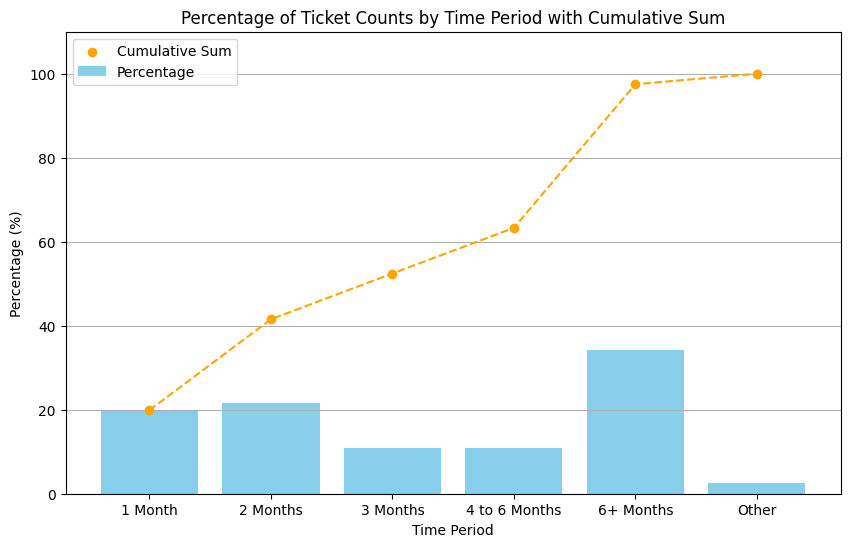

In [307]:
# @title


# Assuming df4_ is your DataFrame with the relevant columns
# Calculate counts for each category
counts = {
    '1 Month': df4_['ticket_count_1_month'].sum(),
    '2 Months': df4_['ticket_count_2_months'].sum(),
    '3 Months': df4_['ticket_count_3_months'].sum(),
    '4 to 6 Months': df4_['ticket_count_4_to_6_months'].sum(),
    '6+ Months': df4_['ticket_count_6_months_plus'].sum(),
    'Other': df4_['ticket_count_other'].sum()
}

# Calculate the total count
total_count = sum(counts.values())

# Calculate percentages
percentages = {key: (value / total_count) * 100 for key, value in counts.items()}

# Calculate cumulative sums of percentages
cumulative_percentages = pd.Series(percentages).cumsum()

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(percentages.keys(), percentages.values(), color='skyblue', label='Percentage')
plt.title('Percentage of Ticket Counts by Time Period with Cumulative Sum')
plt.xlabel('Time Period')
plt.ylabel('Percentage (%)')
plt.ylim(0, 110)  # Set y-axis limit to slightly above 100% for visibility
plt.grid(axis='y')

# Add cumulative sum scatter plot
plt.scatter(cumulative_percentages.index, cumulative_percentages.values, color='orange', label='Cumulative Sum', zorder=5)
plt.plot(cumulative_percentages.index, cumulative_percentages.values, color='orange', linestyle='--', zorder=4)

# Add legend
plt.legend()

# Show the plot
plt.show()

## Analysis of Upcoming Subscription Endings by ARR Band and CRM Term

In [308]:
# @title
import pandas as pd
from IPython.display import display, HTML


# Step 1: Create separate DataFrames for each ARR band
bands = df5['arr_band'].unique()
dfs = {band: df5[df5['arr_band'] == band] for band in bands}

# Step 2: Create pivot tables for each DataFrame
pivot_tables = {}
for band, df in dfs.items():
    pivot_table = df.pivot_table(
        index='time_to_renew_mapped',
        columns='crm_term',
        values='distinct_account_count',
        aggfunc='sum',
        fill_value=0  # Fill missing values with 0
    )
    pivot_tables[band] = pivot_table

# Step 3: Define a function to style and display the pivot tables
def display_styled_table(pivot_table, title):
    html_table = pivot_table.to_html(classes='table', border=0)
    styled_table = f"""
    <h3>{title}</h3>
    <style>
    .table {{
        width: auto; /* Adjust as needed */
        table-layout: auto; /* Adjust as needed */
        overflow-x: auto;
        border-collapse: collapse;
    }}
    .table th, .table td {{
        border: 1px solid #ddd;
        padding: 8px;
        text-align: center;
    }}
    .table th {{
        background-color: #f2f2f2;
    }}
    </style>
    {html_table}
    """
    display(HTML(styled_table))

# Step 4: Print the styled tables for each band
for band, pivot_table in pivot_tables.items():
    display_styled_table(pivot_table, f"Pivot Table for {band}")

crm_term,2 year,Annual,Quarterly,Semi-Annual
time_to_renew_mapped,,,,
1.0,27,63,5,4
2.0,32,158,5,8
3.0,20,65,4,2
4.0,34,94,0,6
5.0,83,188,0,9
6.0,14,76,0,3
7.0,20,61,0,0
8.0,20,95,0,1
9.0,32,103,0,0


crm_term,2 year,Annual,Quarterly,Semi-Annual
time_to_renew_mapped,,,,
1.0,90,863,30,13
2.0,132,1099,56,16
3.0,68,686,18,18
4.0,93,764,0,16
5.0,255,1239,1,25
6.0,80,596,1,12
7.0,57,606,0,2
8.0,107,807,0,0
9.0,107,831,0,0


crm_term,2 year,Annual,Quarterly,Semi-Annual
time_to_renew_mapped,,,,
1.0,172,5495,244,273
2.0,110,4577,194,132
3.0,56,4036,184,222
4.0,79,3953,2,125
5.0,157,4587,2,66
6.0,79,3891,0,67
7.0,83,3725,2,2
8.0,78,3982,1,2
9.0,67,4104,2,2


In [309]:
df7.head(20)

,article_title,kcs_events
0,Downgrading and removing an agent,1004
1,Zendesk’s 2023 Pricing Update: What You Need T...,332
2,Viewing and managing plan subscriptions,300
3,Contacting Zendesk Customer Support,204
4,Zendesk Service Data Deletion Policy,173
5,Managing invoices,129
6,How do I export my data and reports from all o...,114
7,Who is the owner of my account?,95
8,How do I reduce the number of agent seats on m...,91
9,"Exporting ticket, user, or organization data f...",83


In [310]:
# Assuming df8 is your DataFrame and 'no_of_handoffs' is the column
df8['no_of_handoffs'] = df8['no_of_handoffs'].fillna(-1)
df8['no_of_handoffs'] = df8['no_of_handoffs'].map(lambda x: 4 if x > 4 else x).astype(int)


In [311]:
# prompt: df8.value_counts('no_of_handoffs')
# reset index and add a column with % of total

# Value counts for 'no_of_handoffs'
value_counts = df8['no_of_handoffs'].value_counts().reset_index()
value_counts.columns = ['no_of_handoffs', 'count']

# Calculate the percentage of total
value_counts['percentage'] = (value_counts['count'] / value_counts['count'].sum()) * 100

value_counts


,no_of_handoffs,count,percentage
0,0,4631,42.820157
1,1,2596,24.003699
2,2,1694,15.663430
3,4,895,8.275543
4,3,811,7.498844
5,-1,188,1.738326


In [312]:
df8.group_id_order.value_counts().head(49)

,count
group_id_order,
Sales - Renewals AMER,1433
Sales - Renewals EMEA,849
Renewals - Triage,774
Advocacy - Triage,721
Sales - Renewals APAC,453
RevOps - Customer Support (FSS) > Sales - Renewals AMER,265
Sales - Renewals AMER > Renewal Managers > Sales - Renewals AMER,236
Sales - Renewals LATAM,230
Advocacy - Triage > Sales - Renewals APAC,226


In [313]:
# prompt: group df by has_public_comment, 'arr_greater_than_100k',
#        'arr_is_null_or_zero', 'arr_less_than_12k', 'arr_between_12k_and_100k'
# agg by count rows
df = pd.read_csv('/content/drive/My Drive/Renewals_csvs/bquxjob_5d686f4d_19554626267.csv')
df2 = pd.read_csv('/content/drive/My Drive/Renewals_csvs/bquxjob_4c85cef_1955d9ddf8f.csv')
df3 = pd.read_csv('/content/drive/My Drive/Renewals_csvs/bquxjob_27dcf080_195546fac11.csv')
df = pd.merge(df, df2, on='ticket_id', how='inner')
df = pd.merge(df, df3, on='ticket_id', how='inner')
df = pd.merge(df, df3_handoffs, on='ticket_id', how='inner')
df_no_public_comments = df.query('has_public_comment == 0 & is_zd == 1')
grouped_df = df_no_public_comments.groupby(['has_public_comment', 'arr_greater_than_100k', 'arr_is_null_or_zero', 'arr_less_than_12k', 'arr_between_12k_and_100k']).size().reset_index(name='count')
grouped_df.sort_values(by='count', ascending=False)


,has_public_comment,arr_greater_than_100k,arr_is_null_or_zero,arr_less_than_12k,arr_between_12k_and_100k,count
0,0,0,1,0,0,502


In [314]:
grouped_df = df.groupby('has_public_comment').size().reset_index(name='count')
grouped_df.sort_values(by='count', ascending=False)

,has_public_comment,count
1,1,9004
0,0,1764


In [315]:
grouped_df.query('has_public_comment == 0')['count'].sum()/grouped_df['count'].sum()

0.1638187221396731

## Churn rate analysis

In [316]:
df9

,zendesk_account_id,crm_win_dt,crm_churn_dt,tix_2022,tix_2023,tix_2024,tix_2025
0,1265338,2012-02-13,NaN,0,0,0,0
1,17974076,2014-10-28,2024-06-16,0,0,0,0
2,18135480,2017-06-02,NaN,0,0,0,0
3,679930,2015-03-28,NaN,0,0,0,0
4,9855404,NaN,NaN,0,0,0,0
...,...,...,...,...,...,...,...
179753,53037,2011-01-21,2025-01-08,0,0,0,0
179754,17634359,2016-08-22,NaN,0,0,0,0
179755,709809,2015-05-05,NaN,0,0,0,0
179756,933210,2016-04-18,NaN,0,0,0,0


In [317]:
df9['instance_engaged_flag'] = (df9[['tix_2022', 'tix_2023', 'tix_2024', 'tix_2025']].sum(axis=1) > 0).astype(int)
df9['is_churn_flag'] = df9['crm_churn_dt'].notnull().astype(int)
df9['tix_2022_'] = (df9['tix_2022'] > 0).astype(int)
df9['tix_2023_'] = (df9['tix_2023'] > 0).astype(int)
df9['tix_2024_'] = (df9['tix_2024'] > 0).astype(int)
df9['tix_2025_'] = (df9['tix_2025'] > 0).astype(int)


In [318]:
df10.head()

,crm_term,month_label,instances_count,tix,percentage,instances_count_1,tix_1,percentage_1,arr_band,Unnamed: 9,...,count month_label,Unnamed: 14,MIN_instances_count,max_instances_count,avg_instances_count,Unnamed: 18,crm_term.2,percentage_1.2,count month_label.1,avg instances_count
0,Annual,01 Jan-24,52063,249,0.5,49092,164,0.3,Less than $12K,NaN,...,13.0,NaN,1598.0,1742.0,1658.0,NaN,2 year,1.14,13.0,4964.0
1,Annual,02 Feb-24,51604,220,0.4,49092,164,0.3,Less than $12K,NaN,...,13.0,NaN,1950.0,2113.0,2052.0,NaN,3+ years,0.76,13.0,4598.0
2,Annual,03 Mar-24,51146,225,0.4,49092,164,0.3,Less than $12K,NaN,...,13.0,NaN,3220.0,4782.0,4428.0,NaN,Annual,0.74,13.0,66903.0
3,Annual,04 Apr-24,50571,205,0.4,49092,164,0.3,Less than $12K,NaN,...,13.0,NaN,199.0,230.0,216.0,NaN,Monthly,0.39,13.0,44644.0
4,Annual,05 May-24,50062,258,0.5,49092,164,0.3,Less than $12K,NaN,...,13.0,NaN,20.0,46.0,28.0,NaN,Quarterly,1.24,13.0,803.0


 ## Ratio of tickets to active instances per ARR band and CRM term

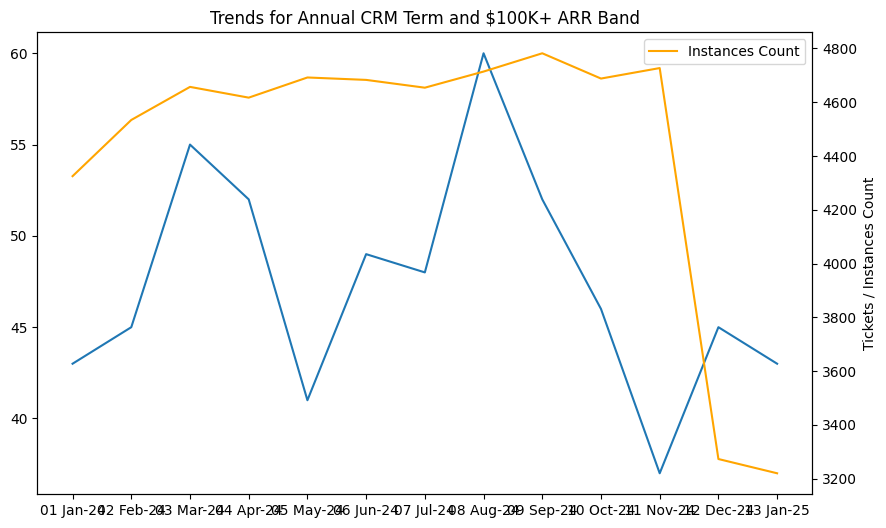

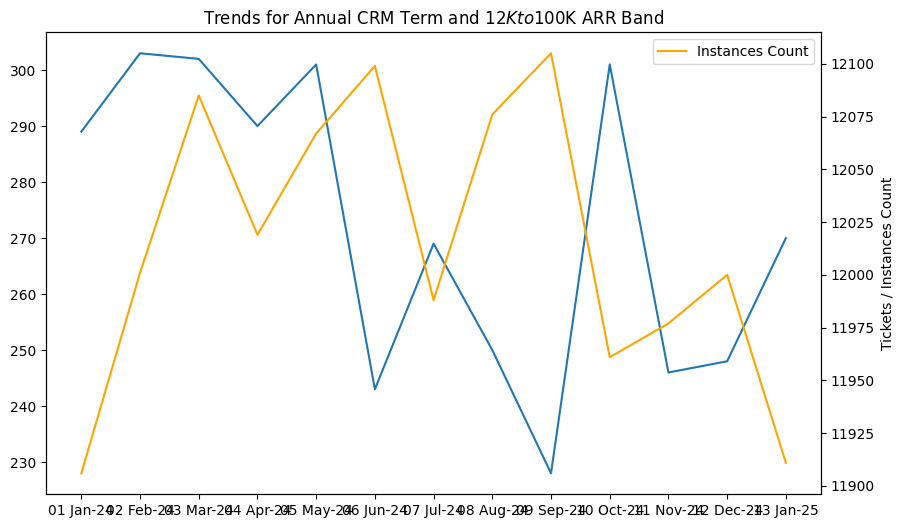

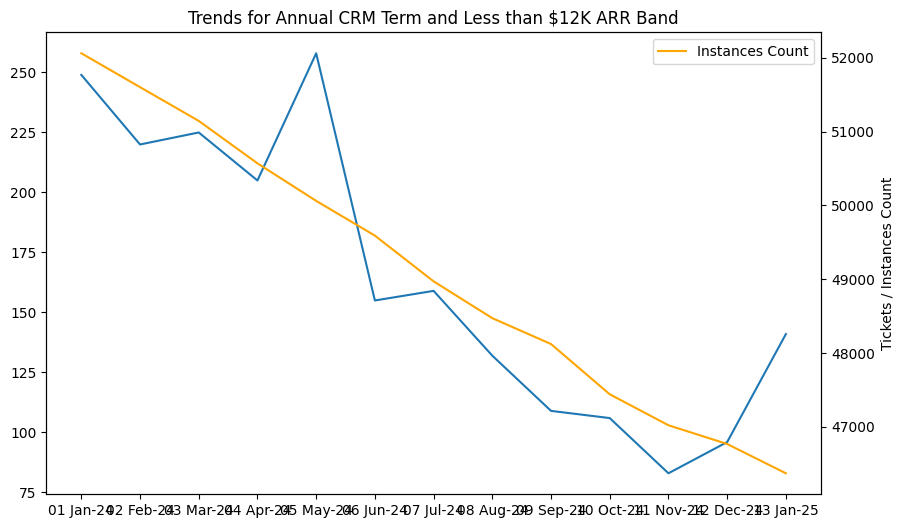

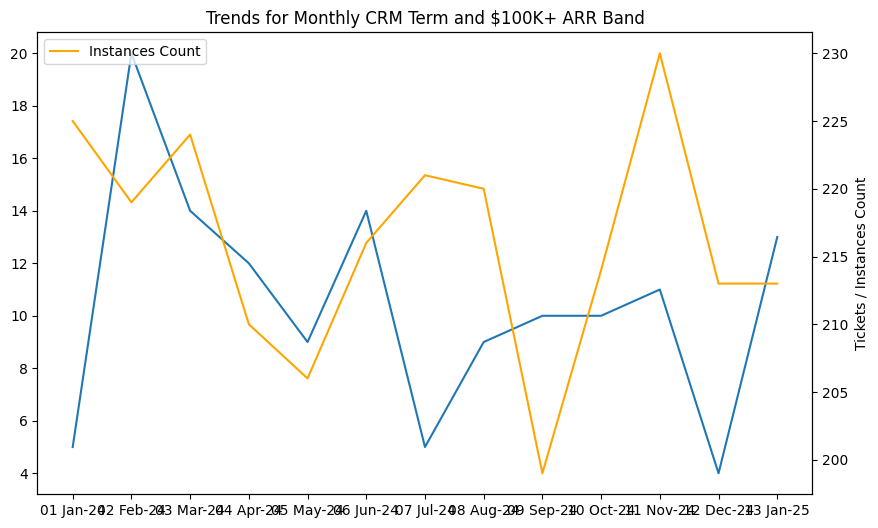

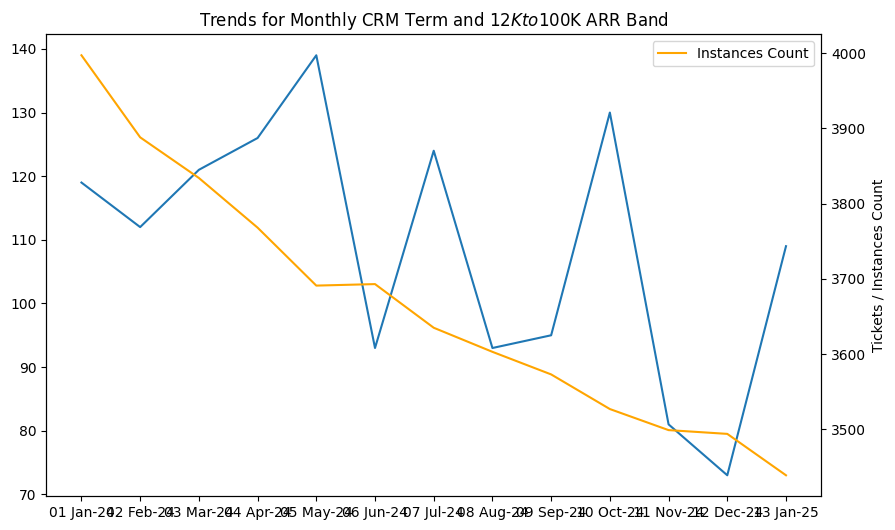

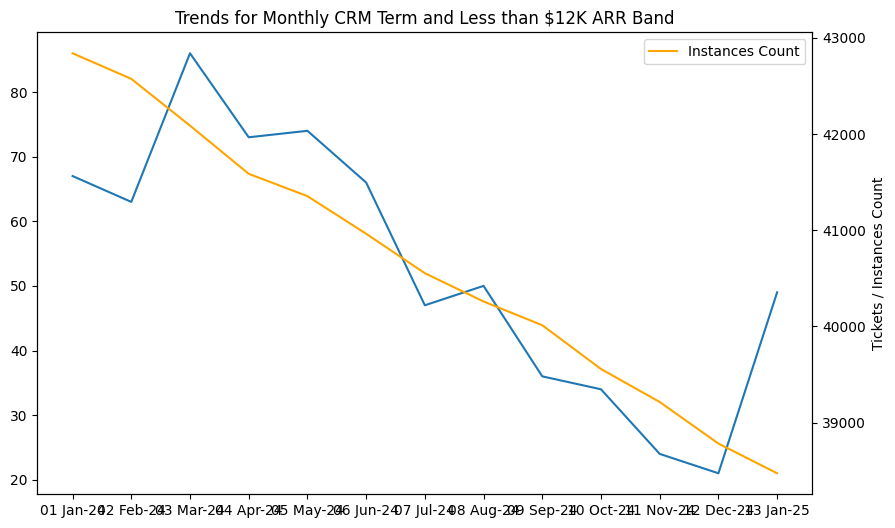

In [319]:
# @title
import matplotlib.pyplot as plt

def plot_trends(df, title):
    plt.figure(figsize=(10, 6))
    plt.plot(df['month_label'], df['tix'], label='Tickets')
    plt.twinx()
    plt.plot(df['month_label'], df['instances_count'], color='orange', label='Instances Count')
    plt.title(title)
    plt.xlabel('Month')
    plt.ylabel('Tickets / Instances Count')
    plt.legend()
    plt.show()

# Assuming df9 is your DataFrame with the first 9 columns
df10 = df10.iloc[:, :9]

# Create the six DataFrames using query
df_annual_100k = df10.query("crm_term == 'Annual' and arr_band == '$100K+'")
df_annual_12k_100k = df10.query("crm_term == 'Annual' and arr_band == '$12K to $100K'")
df_annual_less_12k = df10.query("crm_term == 'Annual' and arr_band == 'Less than $12K'")
df_monthly_100k = df10.query("crm_term == 'Monthly' and arr_band == '$100K+'")
df_monthly_12k_100k = df10.query("crm_term == 'Monthly' and arr_band == '$12K to $100K'")
df_monthly_less_12k = df10.query("crm_term == 'Monthly' and arr_band == 'Less than $12K'")

# List of DataFrames and their corresponding titles
dataframes = [
    (df_annual_100k, "Trends for Annual CRM Term and $100K+ ARR Band"),
    (df_annual_12k_100k, "Trends for Annual CRM Term and $12K to $100K ARR Band"),
    (df_annual_less_12k, "Trends for Annual CRM Term and Less than $12K ARR Band"),
    (df_monthly_100k, "Trends for Monthly CRM Term and $100K+ ARR Band"),
    (df_monthly_12k_100k, "Trends for Monthly CRM Term and $12K to $100K ARR Band"),
    (df_monthly_less_12k, "Trends for Monthly CRM Term and Less than $12K ARR Band"),
]

# Apply the plotting function to each DataFrame
for df, title in dataframes:
    if not df.empty:
        plot_trends(df, title)
    else:
        print(f"No data found for {title}")